<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_9_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Practical Week 9: Photometric stereo

Today you are going to do something very cool! Given only a stack of images taken from the same viewpoint under different lighting conditions, you are going to:

1. *Inverse render* the images by recovering a normal map and albedo map using photometric stereo
2. Do a very basic rendering of your recovered model with new light source directions

As an extra challenge, you can have a go at trying to improve the basic algorithm by excluding shadowed pixel values.

You will need to refer to the Week 9, Video Lecture 1 slides.

##0. Imports and data loading

The dataset comprises 20 images, a binary object mask and a light source direction for each image. Let's start by importing libraries and downloading the dataset.

In [1]:
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

!wget https://www-users.cs.york.ac.uk/wsmith/VICO/PSdata.zip
!unzip PSdata.zip

--2024-12-28 17:01:14--  https://www-users.cs.york.ac.uk/wsmith/VICO/PSdata.zip
Resolving www-users.cs.york.ac.uk (www-users.cs.york.ac.uk)... 144.32.128.40, 2001:630:61:180::1:28
Connecting to www-users.cs.york.ac.uk (www-users.cs.york.ac.uk)|144.32.128.40|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www-users.york.ac.uk/~waps101/VICO/PSdata.zip [following]
--2024-12-28 17:01:14--  https://www-users.york.ac.uk/~waps101/VICO/PSdata.zip
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2211444 (2.1M) [application/zip]
Saving to: ‘PSdata.zip’

PSdata.zip          100%[===================>]   2.11M  4.67MB/s    in 0.5s    

2024-12-28 17:01:15 (4.67 MB/s) - ‘PSdata.zip’ saved [2211444/2211444]

Archive:  PSdata.zip
  inflating: mask.png            

The light source directions for each image are stored in a text file. We will load these into a 2D array `S` of size $20\times 3$ so that each row of `S` contains a unit vector pointing in the direction of the light source for that image.

In [2]:
# Load light source directions
reader = csv.reader(open("refined_light.txt"), skipinitialspace=True)
S = np.zeros((3,20))
for i,row in enumerate(reader):
  S[i,:] = np.array(row, dtype=np.float32)
S = np.transpose(S) # Light source directions now stored in 20x3 matrix
for i in range(20):
  # Ensure unit length
  S[i,:] = S[i,:] / np.linalg.norm(S[i,:])

The mask is a binary image used to indicate which pixels belong to the foreground.

(-0.5, 499.5, 639.5, -0.5)

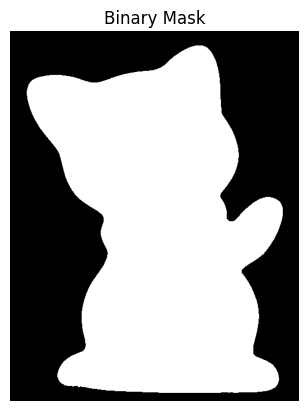

In [3]:
# Load the binary mask (0 for background, 1 for foreground)
mask = np.asarray(cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE))>0
plt.imshow(mask, cmap="gray")
plt.title('Binary Mask')
plt.axis('off')

Finally, we'll load the 20 images in the dataset. They will be stored in `images`, an array of size $20\times 640 \times 500$ containing intensity values in the range $[0,1]$.

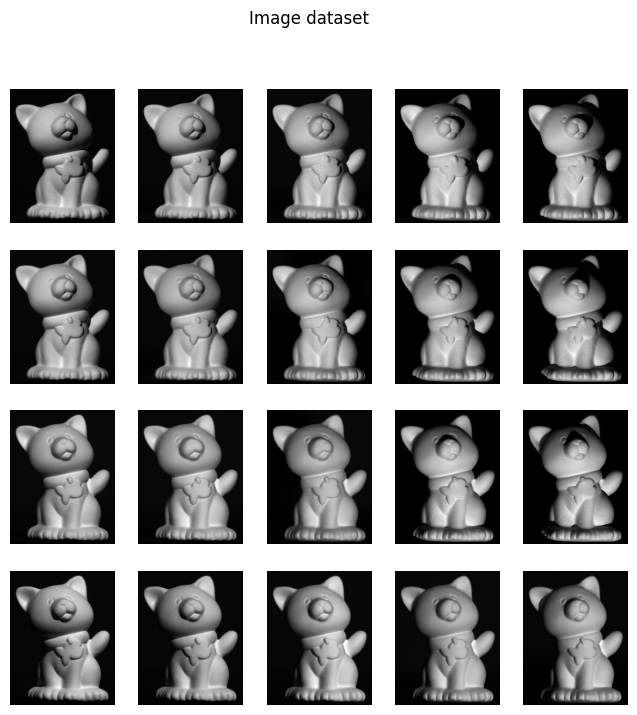

In [4]:
# Load and display the images
figure = plt.figure(figsize=(8, 8))
images = []
for i in range(1,21):
  figure.add_subplot(4, 5, i)
  fname = "Image_{:02d}.png".format(i)
  im = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
  images.append(im)
  plt.imshow(im, cmap="gray")
  plt.axis('off')
plt.suptitle('Image dataset')
plt.show()
# Convert intensity values to floats between 0 and 1
images = np.asarray(images)
images = images.astype(np.float32)/255.0

##1. Computing light source intensity

Recall that in the photometric stereo lecture that the light source vector was scaled by some constants (the radiance of the light source and a normalising constant). You now need estimate this scale factor from the images. Making a few assumptions, we can say that the brightest point in the image corresponds to the strength of the light source. For robustness, we'll use the 99th percentile instead of the actual max value. For each image, consider only the foreground masked region, extract the intensities, sort them and take the 99th percentile brightest value. Scale the light source direction for this image by this value.

In [6]:
for i, image in enumerate(images):
  intensities = []
  for y in range(len(image)):
    for x in range(len(image[y])):
      if mask[y][x]:
        intensities.append(image[y][x])

  intensities.sort()
  percentile = intensities[int(len(intensities) * 0.99)]
  S[i] = S[i] * percentile


##2. Photometric stereo

It's time to perform photometric stereo. The objective is to use the $20\times 640 \times 500$ array `images` containing all of the image data and the $20\times 3$ scaled light source vectors to compute a $640\times 500 \times 3$ surface normal map and $640\times 500$ albedo map. Implement the following pseudocode:

1. Compute the pseudoinverse of your lighting matrix
2. Initialise normal map and albedo map to zeros
3. For every foreground pixel in your image:
  1. Extract a vector of the 20 intensity values for that pixel
  2. Compute the albedo and surface normal for that pixel (as shown in the slides)

In [22]:
S_plus = np.linalg.pinv(S)
N = np.zeros((640, 500, 3))
albedo = np.zeros((640, 500))

for y in range(len(albedo)):
  for x in range(len(albedo[y])):
    if not mask[y][x]:
      continue
    intensities = [image[y][x] for image in images]
    v = np.dot(S_plus, intensities)
    albedo[y][x] = np.linalg.norm(v)
    N[y][x] = v / albedo[y][x]


##3. Visualise the normal map and albedo map

You should now have an array `N` of size $640\times 500\times 3$ containing the estimated surface normals for each pixel. The elements of the surface normal vectors are values in the range $[-1,1]$. For visualisation, we can display the normal map as an RGB image by shifting and scaling to the range $[0,1]$. i.e. the $x$ value of the surface normal vectors is shown in the red channel, $y$ in green and $z$ in blue. To do this, simply take your normal map, add 1 and divide by 2 and display it as an image. You should observe that parts of the surface that are pointing to the right should be red, pointing upwards should be green and pointing towards the viewer blue.

The albedo map is just like a grayscale image. It shows how reflective each part of the surface is. Since this object is pretty much uniform white, there's not much interesting to see in it. However, you might notice some weird bright patches. These are artefacts caused by misinterpreting the cast shadows that you will try to fix later.

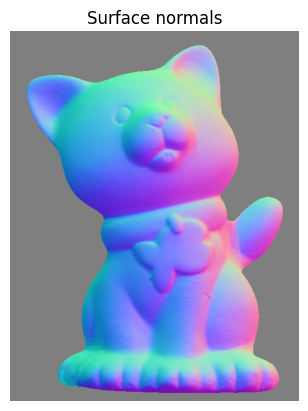

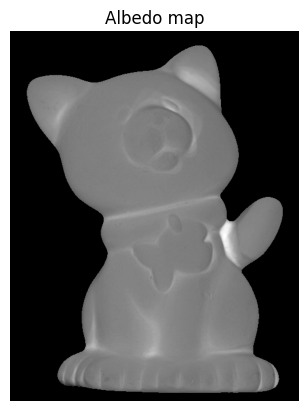

In [23]:
N_display = (N + 1)/ 2
plt.imshow(N_display)
plt.title('Surface normals')
plt.axis('off')
plt.show()
plt.imshow(albedo, cmap="gray")
plt.title('Albedo map')
plt.axis('off')
plt.show()

##4. Render an image with a new light source direction

We can perform a very basic kind of rendering using only the normal map and albedo map and a given light source direction. For each foreground pixel, we know the surface normal vector $\mathbf{n}$ and albedo $\rho_d$. If we choose a new light source direction, e.g. $\mathbf{s}=[-1,0,0]^{\top}$ we can compute the rendered intensity using:
$$
i = \rho_d\max(0,\mathbf{n}\cdot\mathbf{s})
$$
(the max ensures we don't get negative values when the light source is more than 90 degrees from the surface normal). Do this for every pixel then display the resulting grayscale image.

**Extra challenge**: gradually rotate the light source around the object and make an animation of the resulting images.

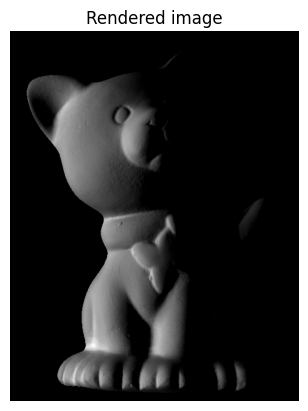

In [24]:
image = np.zeros((640, 500))
s = np.array([-1, 0, 0])
for y in range(len(image)):
  for x in range(len(image[y])):
    if not mask[y][x]:
      continue
    image[y][x] = albedo[y][x] * (max(0, np.dot(N[y][x], s)))

plt.imshow(image, cmap="gray")
plt.title('Rendered image')
plt.axis('off')
plt.show()

##5. Extra challenge: excluding shadows

The main source of error in our results are caused by shadows. For example, the fifth image has a strong cast shadow above the nose:

(-0.5, 499.5, 639.5, -0.5)

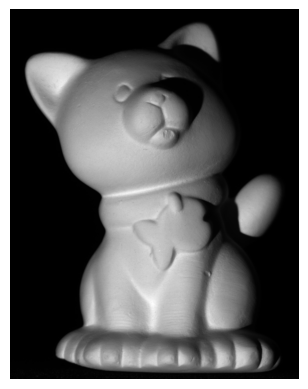

In [25]:
plt.imshow(images[4,:,:],cmap="gray")
plt.axis('off')

See if you can improve your result by detecting and excluding shadowed values. These will be different for each pixel. And you'll end up using a different subset of light directions for each pixel so will need to compute a specific pseudoinverse for each pixel. The simplest thing you might do is just exclude dark values, e.g. when the intensity is $<0.1$. However, you could do something fancier like use RANSAC to fit to the observations and try to detect the shadowed values as outliers. If you succeed, you should see that the albedo map loses some of the bright artefacts you had before. You might also want to visualise the binary shadow maps that you infer and see if they look plausible.